In [1]:
#importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torchvision import datasets,transforms,models
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import *

import time
import json
import copy
import os

from PIL import Image
from collections import OrderedDict

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
# Tansform with data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        #transforms.RandomResizedCrop(299),  #size for inception architecture
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        #transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    'test': transforms.Compose([
        transforms.Resize(256),                                  
        transforms.CenterCrop(224),
        #transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
}

In [3]:
#Loading in the dataset

train_dir = './car_data/car_data/car_data/train'
test_dir = './car_data/car_data/car_data/test'
label_dir = 'names.csv'

batch_size=16
dataset = datasets.ImageFolder(train_dir,transform=data_transforms['train'])

# splitting our data
valid_size  = int(0.1 * len(dataset))
train_size = len(dataset) - valid_size
dataset_sizes = {'train': train_size, 'valid': valid_size}

# now we get our datasets
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

# Loading datasets into dataloader 
dataloaders = {'train': DataLoader(train_dataset, batch_size = batch_size, shuffle = True),
              'valid': DataLoader(valid_dataset, batch_size = batch_size, shuffle = False)}

print("Total Number of Samples: ",len(dataset))
print("Number of Samples in Train: ",len(train_dataset))
print("Number of Samples in Valid: ",len(valid_dataset))
print("Number of Classes: ",len(dataset.classes))

print(dataset.classes[0])

Total Number of Samples:  8144
Number of Samples in Train:  7330
Number of Samples in Valid:  814
Number of Classes:  196
AM General Hummer SUV 2000


 Sizes of Datasets:  814 7330


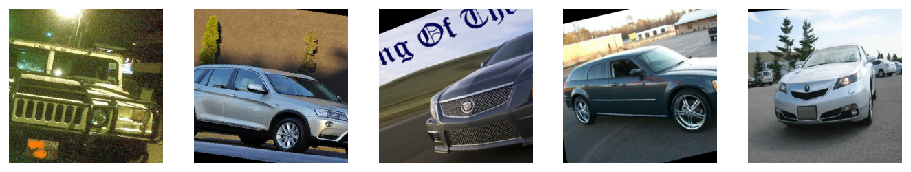

In [50]:
## Method to display Image for Tensor
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax


print(" Sizes of Datasets: ", len(valid_dataset), len(train_dataset))
# Displaying Training Images
images, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(figsize=(16,5), ncols=5)
for ii in range(5):
    ax = axes[ii]
    #ax.set_title(label_map[class_names[labels[ii].item()]])
    imshow(images[ii], ax=ax, normalize=True)

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = 'resnet' #vgg
# Densenet
if model_name == 'densenet':
    model = models.densenet161(pretrained=True)
    num_in_features = 2208
    print(model)
# VGGNet
elif model_name == 'vgg':
    model = models.vgg19(pretrained=True)
    num_in_features = 25088
    print(model.classifier)
# Resnet
elif model_name == 'resnet':
    model = models.resnet152(pretrained=True) 
    #model = models.resnet34(pretrained=True)
    num_in_features = 2048 #512 
    print(model.fc)
# Inception
elif model_name == 'inception':
  model = models.inception_v3(pretrained=True)
  model.aux_logits=False
  num_in_features = 2048
  print(model.fc)
else:
    print("Unknown model, please choose 'densenet' or 'vgg'")

Linear(in_features=2048, out_features=1000, bias=True)


In [52]:
# Freezing parameters
for param in model.parameters():
  param.require_grad = False
  
# Create Custom Classifier
def build_classifier(num_in_features, hidden_layers, num_out_features):
    classifier = nn.Sequential()
    # when we don't have any hidden layers
    if hidden_layers == None:      
        classifier.add_module('fc0', nn.Linear(num_in_features, 196))    
    #when we have hidden layers
    else:      
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        classifier.add_module('fc0', nn.Linear(num_in_features, hidden_layers[0]))
        classifier.add_module('relu0', nn.ReLU())
        classifier.add_module('drop0', nn.Dropout(.6))
        
        for i, (h1, h2) in enumerate(layer_sizes):
            classifier.add_module('fc'+str(i+1), nn.Linear(h1, h2))
            classifier.add_module('relu'+str(i+1), nn.ReLU())
            classifier.add_module('drop'+str(i+1), nn.Dropout(.5))
        classifier.add_module('output', nn.Linear(hidden_layers[-1], num_out_features))
        
    return classifier

In [53]:
#define our hidden layers
hidden_layers = None #[1050,500]
classifier = build_classifier(num_in_features, hidden_layers, 196)
print(classifier)
 # Defining model hyperparameters
if model_name == 'densenet':
    model.classifier = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adadelta(model.parameters()) # Adadelta #weight optim.Adam(model.parameters(), lr=0.001, momentum=0.9)
   # Decay Learning Rate by a factor of 0.1 every 4 epochs
    sched = optim.lr_scheduler.StepLR(optimizer, step_size=4)
elif model_name == 'vgg':
    model.classifier = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
    sched = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
elif model_name == 'resnet':
  model.fc = classifier
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  sched = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
elif model_name == 'inception':
    model.fc = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)
else:
    pass

Sequential(
  (fc0): Linear(in_features=2048, out_features=196, bias=True)
)


In [56]:
# Training 
def train_model(model, criterion, optimizer, sched, num_epochs=5,device='cuda'):
    start = time.time()
    train_results = []
    valid_results = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':            
              model.train()  # Set model to training mode
            else:
              model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        #sched.step()
                        loss.backward()
                        
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if(phase == 'train'):
              train_results.append([epoch_loss,epoch_acc])
            if(phase == 'valid'):
              valid_results.append([epoch_loss,epoch_acc])
                                   
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model (Early Stopping) and Saving our model, when we get best accuracy
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())       
                model_save_name = "resnetCars.pt"
                path = F"./car_data/{model_save_name}"
                torch.save(model.state_dict(), path)        

        print()

    # Calculating time it took for model to train    
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #load best model weights
    model.load_state_dict(best_model_wts)
    
    return model,train_results,valid_results

In [57]:
epochs = 60
#move model to GPU
model.to(device)
model,train_results,valid_results = train_model(model, criterion, optimizer, sched, epochs)

Epoch 1/60
----------
train Loss: 4.8915 Acc: 0.0263
valid Loss: 4.9246 Acc: 0.0295

Epoch 2/60
----------
train Loss: 4.4302 Acc: 0.0662
valid Loss: 4.9283 Acc: 0.0713

Epoch 3/60
----------
train Loss: 3.8134 Acc: 0.1330
valid Loss: 3.7248 Acc: 0.1536

Epoch 4/60
----------
train Loss: 3.3010 Acc: 0.2119
valid Loss: 3.3154 Acc: 0.2371

Epoch 5/60
----------
train Loss: 2.8949 Acc: 0.2920
valid Loss: 3.3545 Acc: 0.2703

Epoch 6/60
----------
train Loss: 2.5686 Acc: 0.3521
valid Loss: 2.9952 Acc: 0.2998

Epoch 7/60
----------
train Loss: 2.3145 Acc: 0.4119
valid Loss: 2.9257 Acc: 0.3096

Epoch 8/60
----------
train Loss: 2.0866 Acc: 0.4589
valid Loss: 2.6454 Acc: 0.3722

Epoch 9/60
----------
train Loss: 1.9105 Acc: 0.5071
valid Loss: 2.4032 Acc: 0.4251

Epoch 10/60
----------
train Loss: 1.7789 Acc: 0.5333
valid Loss: 2.3468 Acc: 0.4398

Epoch 11/60
----------
train Loss: 1.6454 Acc: 0.5662
valid Loss: 2.3120 Acc: 0.4459

Epoch 12/60
----------
train Loss: 1.5476 Acc: 0.6003
valid Los

In [60]:
model.load_state_dict(torch.load('./car_data/ResnetCars.pt'))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [67]:
# import pathlib libary to get filename without the extension
from pathlib import Path

# Load the datasets with ImageFolder
label_df = pd.read_csv('./car_data/names.csv', names=["label"])

test_dir = './car_data/car_data/car_data/test'

with torch.no_grad():
  print("Predictions on Test Set:")
  model.eval()  
  dataset = datasets.ImageFolder(test_dir,transform=data_transforms['test'])
  
  testloader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                             shuffle=False, num_workers=2)
 
  image_names = []
  pred = []
  for index in testloader.dataset.imgs:
    image_names.append(Path(index[0]).stem)
    
  results = []
  file_names = []
  predicted_car = []
  predicted_class = []

  for inputs,labels in testloader:
    inputs = inputs.to(device)
    #labels = labels.to(device)
    outputs = model(inputs)
    _, pred = torch.max(outputs, 1) 
    
    for i in range(len(inputs)):
      file_names.append(image_names[i])
      predicted_car.append(int(pred[i] + 1))
      
results.append((file_names, predicted_car))

Predictions on Test Set:


In [70]:
print("Predictions on Test Set:")
df = pd.DataFrame({'Id': image_names, 'Predicted': results})
pd.set_option('display.max_colwidth', -1)

# df = df.sort_values(by=['Id']) 
df.to_csv('./car_data/predictions.csv')
df

Predictions on Test Set:


ValueError: arrays must all be same length